In [1]:
import numpy as np
import matplotlib
#%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib as mpl
from sklearn import datasets
#mpl.rcParams['figure.dpi'] = 600

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")


In [2]:
random_state = 42
n_samples = 40
X, y = datasets.make_blobs(
    centers=[[0.25, 0.25], [0.75, 0.75]], 
    n_samples=n_samples, 
    random_state=random_state, 
    cluster_std=0.15)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(X, transformation)
# X, y = (X_aniso, y)



# x_true = np.random.normal(4, 1, n_true)
# y_true = np.random.normal(3, 25, n_true)

# n_false = 20
# x_false = np.random.normal(8, 1, n_false)
# y_false = np.random.normal(2, 25, n_false)

# a = -5
# b = 21.5

# y_true = y_true + 4 * (a * x_true + b)
# y_false = 4 * (- a * x_false + b) - y_false

# _x = np.hstack([x_true, x_false])
# _y = np.hstack([y_true, y_false])
# _y -= np.min(_y)
# _y /= np.max(_y)
# _x /= np.max(_x) * 1.1
# X = np.array(list(zip(_x, _y)))

# y = np.hstack([np.ones(n_true), np.zeros(n_false)])

# print(X.shape, y.shape)

In [3]:
p2, p3 = [0.25, 0.35], [0.35, 0.25]
X2 = np.vstack([X, p2])
y2 = np.append(y, [1])
X3 = np.vstack([X, p2, p3])
y3 = np.append(y, [1, 1])


In [4]:
def plot_distances(points, a, b, color="orange"):
    for point in points:
        px, py = point
        x0 = (a * py + px - a * b) / (1 + (a ** 2))
        y0 = (b + (a ** 2) * py + a * px) / (1 + (a ** 2))
        # y0 = (-x0 / a) + (px / a) + py
        sx, sy = [px, x0], [py, y0]
        idx = np.argsort(sx)
        plt.plot(
            np.linspace(*np.array(sx)[idx]),
            np.linspace(*np.array(sy)[idx]),
            color=color, linewidth=1,
            linestyle="--", scalex=False, scaley=False)


In [5]:

def plot_data_and_svm(model, __x, __y, title, filename="image.pdf"):
    plt.figure(figsize=(5, 5))
    all_idx = np.arange(__x.shape[0])
    support_mask = np.in1d(all_idx, model.support_)
    support_color = "lime"
    # plot decision function
    x_min, x_max = np.min(__x[:, 0]), np.max(__x[:, 0])
    y_min, y_max = np.min(__x[:, 1]), np.max(__x[:, 1])
    r_xmin, r_xmax = x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min)
    r_ymin, r_ymax = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)

    if r_xmax - r_xmin > r_ymax - r_ymin:
        half_range = (r_xmax - r_xmin) / 2
        r_ymin, r_ymax = - half_range + (r_ymax + r_ymin) / 2, half_range + (r_ymax + r_ymin) / 2
    else:
        half_range = (r_ymax - r_ymin) / 2
        r_xmin, r_xmax = - half_range + (r_xmax + r_xmin) / 2, half_range + (r_xmax + r_xmin) / 2
    
    h = 0.01
    xx, yy = np.meshgrid(np.arange(r_xmin, r_xmax + h, h),
                         np.arange(r_ymin, r_ymax + h, h))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    
    x_ls = np.linspace(r_xmin, r_xmax)
    coef = - model.coef_[0, 0] / model.coef_[0, 1]
    intercept = - model.intercept_[0] / model.coef_[0, 1]
    y_df = (x_ls * coef + intercept)

    # plot support vectors
    support_dec = model.decision_function(model.support_vectors_)

    # plot support lines
    support_bottom = y_df - 1 / model.coef_[0, 1]
    support_top = y_df + 1 / model.coef_[0, 1]

    # plot non support point in gutter
    support_classes = __y[model.support_]
    supports = model.support_vectors_
    b_top, b_bot = (support_classes == 1) & (support_dec < 1.02), (support_classes == 0) & (support_dec > -1.02)
    print(b_top, supports[b_top, 0], supports[b_top, 1], __y[model.support_[b_top]])
    print(b_bot, supports[b_bot, 0], supports[b_bot, 1], __y[model.support_[b_bot]])
    top, bottom = supports[b_top], supports[b_bot]
    inter_bottom = intercept - 1 / model.coef_[0, 1]
    inter_top = intercept + 1 / model.coef_[0, 1]
    
    scatter = plt.scatter(__x[~support_mask, 0], __x[~support_mask, 1], c=__y[~support_mask], cmap="coolwarm", edgecolors="k", linewidths=0.5, zorder=2)
    plt.scatter(supports[:, 0], supports[:, 1], c=__y[model.support_], cmap="coolwarm", edgecolors="k", linewidths=0, zorder=3)
    plt.scatter(supports[b_bot, 0], supports[b_bot, 1], edgecolors="red", linewidths=2, zorder=2, alpha=1)
    plt.scatter(supports[b_top, 0], supports[b_top, 1], edgecolors="blue", linewidths=2, zorder=2, alpha=1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8, zorder=1)
    plt.plot(x_ls, y_df, linewidth=2, color="k")
    plt.plot(x_ls, support_bottom, linestyle="--", c="k", linewidth=0.75, zorder=3)
    plt.plot(x_ls, support_top, linestyle="--", c="k", linewidth=0.75, zorder=3)
    plot_distances(top, coef, inter_top, color="blue")
    plot_distances(bottom, coef, inter_bottom, color="red")
    # plt.scatter(supports[:, 0], supports[:, 1], marker="x", color=color, zorder=3, linewidths=1)
    
    plt.xlim(r_xmin, r_xmax)
    plt.ylim(r_ymin, r_ymax)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend(*scatter.legend_elements())
    plt.title(title)
    plt.savefig(filename, bbox_inches='tight')


In [6]:
def plot_dboundary(model, __x, __y, filename="image.pdf", title="", pdata=True):
    plt.figure(figsize=(5, 5))
    if pdata:
        scatter = plt.scatter(__x[:, 0], __x[:, 1], c=__y, cmap="coolwarm", edgecolors="k", linewidths=1, zorder=3)
    else:
        scatter = None
    x_min, x_max = np.min(__x[:, 0]), np.max(__x[:, 0])
    y_min, y_max = np.min(__x[:, 1]), np.max(__x[:, 1])
    r_xmin, r_xmax = x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min)
    r_ymin, r_ymax = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)

    if r_xmax - r_xmin > r_ymax - r_ymin:
        half_range = (r_xmax - r_xmin) / 2
        r_ymin, r_ymax = - half_range + (r_ymax + r_ymin) / 2, half_range + (r_ymax + r_ymin) / 2
    else:
        half_range = (r_ymax - r_ymin) / 2
        r_xmin, r_xmax = - half_range + (r_xmax + r_xmin) / 2, half_range + (r_xmax + r_xmin) / 2
    
    h = 0.01
    xx, yy = np.meshgrid(np.arange(r_xmin, r_xmax + h, h),
                         np.arange(r_ymin, r_ymax + h, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8, zorder=1)
    plt.xlim(r_xmin, r_xmax)
    plt.ylim(r_ymin, r_ymax)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if scatter is not None:
        plt.legend(*scatter.legend_elements())
    plt.title(title)
    plt.savefig(filename, bbox_inches='tight')
    
    

[[5.70580316 7.03603209]] (1, 2)
[[0.48688192 0.36511521]
 [0.34715328 0.47845448]
 [0.58404975 0.57056901]]
[-6.34707978] (1,)
[-1.00006504 -0.99987043  0.99993499]
[False False  True] [0.58404975] [0.57056901] [1]
[ True  True False] [0.48688192 0.34715328] [0.36511521 0.47845448] [0 0]


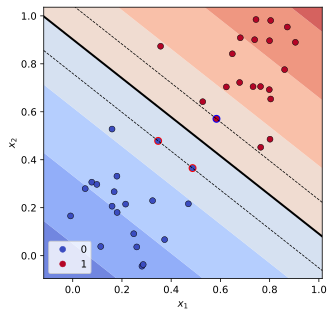

In [7]:
svm = SVC(kernel="linear", C=10000, random_state=42)
svm.fit(X, y)
print(svm.coef_, svm.coef_.shape)
print(svm.support_vectors_)
print(svm.intercept_, svm.intercept_.shape)
print(svm.decision_function(svm.support_vectors_))
plot_data_and_svm(svm, X, y, "", filename="svm_c10000.pdf")

[[4.15097454 4.12710149]] (1, 2)
[-3.84206966] (1,)
[-1.00051997 -0.31416767 -0.9997403  -0.42641504  0.93710219  1.00026077
 -1.35984051 -1.3574532 ]
[False False False False  True  True  True  True] [0.58404975 0.5282217  0.25       0.35      ] [0.57056901 0.64202337 0.35       0.25      ] [1 1 1 1]
[ True  True  True  True False False False False] [0.15974401 0.48688192 0.46984732 0.34715328] [0.52784173 0.36511521 0.21613355 0.47845448] [0 0 0 0]


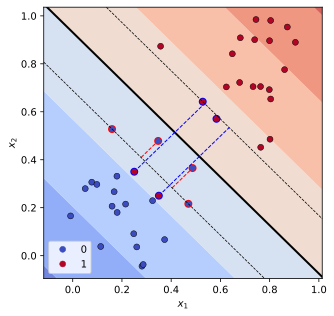

In [8]:
svm2 = SVC(kernel="linear", C=25, random_state=42)
svm2.fit(X3, y3)
print(svm2.coef_, svm2.coef_.shape)
print(svm2.intercept_, svm2.intercept_.shape)
print(svm2.decision_function(svm2.support_vectors_))
plot_data_and_svm(svm2, X3, y3, "", filename="svm_c25.pdf")

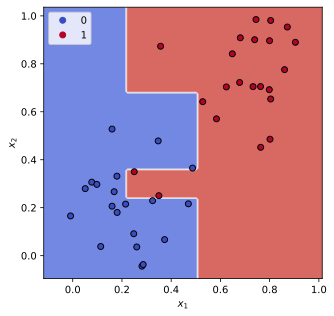

In [9]:
dtree = DecisionTreeClassifier(criterion="entropy")
dtree.fit(X3, y3)
plot_dboundary(dtree, X3, y3, filename="dt_full.pdf")

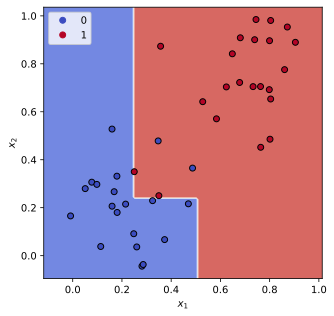

In [10]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
dtree.fit(X3, y3)
plot_dboundary(dtree, X3, y3, filename="dt_max_depth3.pdf")

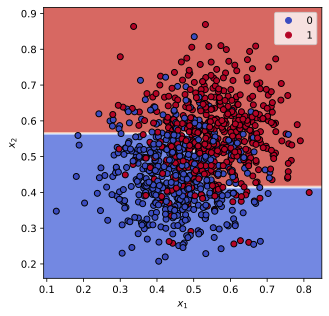

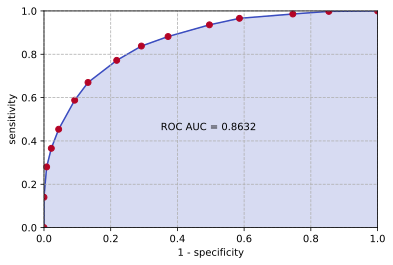

In [11]:
rocX, rocy = datasets.make_blobs(
    centers=[[0.45, 0.45], [0.55, 0.55]], 
    n_samples=1000, 
    random_state=random_state, 
    cluster_std=0.10)

rocdtree = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=50)
rocdtree.fit(rocX, rocy)
plot_dboundary(rocdtree, rocX, rocy)

fpr, tpr, thresh = metrics.roc_curve(rocy, rocdtree.predict_proba(rocX)[:,1])

plt.figure()
plt.plot(fpr, tpr, zorder=1, color="#3B4CC0")
plt.fill_between(fpr, 0, tpr, alpha=0.2, color="#3B4CC0")
plt.scatter(fpr, tpr, c='#B40426')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.text(0.35, 0.45, "ROC AUC = {:.4f}".format(metrics.roc_auc_score(rocy, rocdtree.predict_proba(rocX)[:,1])))
plt.grid(zorder=3, linestyle="--")
plt.xlabel("1 - specificity")
plt.ylabel("sensitivity")
plt.savefig("roc-curve.pdf", bbox_inches='tight')
